In [1]:
#!unzip archive.zip

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy import stats as s

In [3]:
def hypot(x,y): #Computes hypotenuse
  return np.sqrt((x**2)+(y**2))

def difference_points(num_list): 

    best_diff=100000
    for num in num_list:
      for num2 in num_list:
        if not(num==num2):
          diff=np.abs(num-num2)
          if diff<best_diff:
            points=[num,num2]
            best_diff=diff
    return points

def im_components(labels,stats,method=1):
    temp=[]
    for i in range(1,stats.shape[0]):
      width=stats[i,2]
      height=stats[i,3]

      if method==2:  #Considers the component that has height between 5% - 15% and width between 20% - 40% of image
          if (height/stats[0,3] > 0.15 ) or  (height/stats[0,3] < 0.05
                    )or (width/stats[0,2] > 0.4 ) or (width/stats[0,2] < 0.2 ) :
              labels[labels==i]=0
          else:
              temp.append(stats[i,1]+stats[i,3]/2)
      else:
        temp.append(stats[i,1]+stats[i,3]/2)

    new_stats=[]
    closest_points=difference_points(temp)  # Both eyes will be closest to each other on Height axis
    for i in range(1,stats.shape[0]):
      width=stats[i,2]
      height=stats[i,3]
      temp_stat=stats[i,1]+stats[i,3]/2
      if not(temp_stat in closest_points):
        labels[labels==i]=0
      else:
        new_stats.append(stats[i])

    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue==0] = 0
    return np.array(new_stats),labeled_img,temp

def segment_eyeball(img_patch):
    gray = cv2.cvtColor(img_patch, cv2.COLOR_BGR2GRAY)

    blurred = cv2.medianBlur(gray, 5) 

    minDist = 100
    param1 = 1
    param2 = 5

    minRadius = 5
    maxRadius = 100 

    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1, minDist, param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)
    circles = np.uint16(np.around(circles))
    x, y, r = circles[0,:][0]
    rows, cols,ch = img_patch.shape


    for i in range(cols):
        for j in range(rows):
            if hypot(i-x, j-y) > r:
                img_patch[j,i] = 0
    return img_patch

def compute_eyecolor(orig_img,method=2):
    img=cv2.cvtColor(orig_img,cv2.COLOR_BGR2GRAY)
    img = cv2.medianBlur(img,5)
    edges = cv2.Canny(img,50,255)

    kernel = np.ones((3,3),np.uint8)
    edges = cv2.dilate(edges,kernel,iterations = 1)

    edges = cv2.threshold(edges, 127, 255, cv2.THRESH_BINARY)[1]  
    num_labels, labels_im,stats,centroids = cv2.connectedComponentsWithStats(edges)
    stats,labeled_img,temp=im_components(labels_im,stats,method=method)


    plt.imshow(np.hstack([img,edges,255*cv2.cvtColor(labeled_img, cv2.COLOR_BGR2GRAY)]),cmap='gray')
    plt.show()

    img_patch=orig_img[stats[1,1]:stats[1,1]+stats[1,3],stats[1,0]:stats[1,0]+stats[1,2]]
    img_patch=segment_eyeball(img_patch)
    hsv_img_patch=cv2.cvtColor(img_patch, cv2.COLOR_BGR2HSV)

    limit=[]
    for i in range(3):
        temp_list=hsv_img_patch[:,:,i].reshape(-1)
        temp_list=temp_list[temp_list!=0]
        rand_indices=np.unique(np.random.randint(temp_list.shape,size=temp_list.shape)[:500])
        temp_list=temp_list[rand_indices]

        limit.append(s.mode(temp_list)[0][0])

    eye_color=np.zeros(hsv_img_patch.shape).astype(np.uint8)
    eye_color[:,:,0]=int(limit[0])
    eye_color[:,:,1]=int(limit[1])
    eye_color[:,:,2]=int(limit[2])
    eye_color=cv2.cvtColor(eye_color, cv2.COLOR_HSV2RGB)
    HEX_color='#%02x%02x%02x' % (eye_color[0,0,0], eye_color[0,0,1], eye_color[0,0,2])
    plt.imshow(np.hstack([cv2.cvtColor(img_patch, cv2.COLOR_BGR2RGB),eye_color]))
    plt.title('Eye color for '+file+' : '+str(HEX_color))
    plt.show()

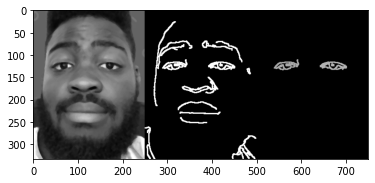

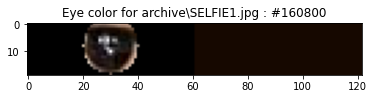

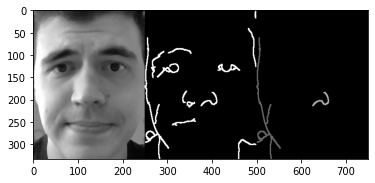

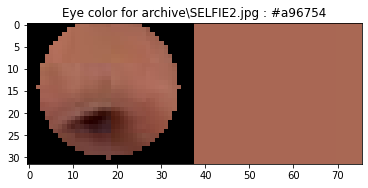

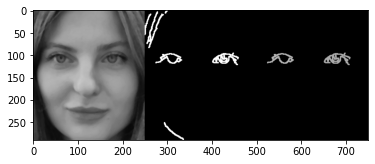

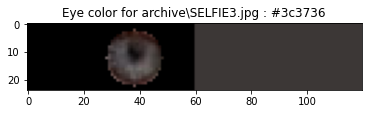

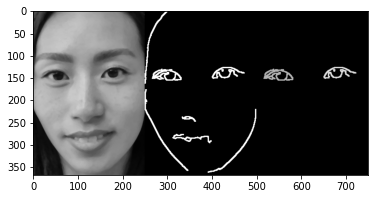

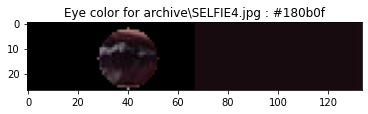

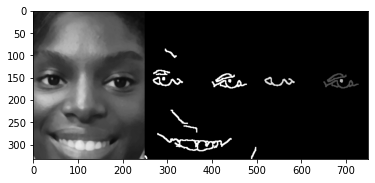

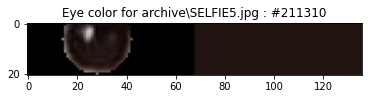

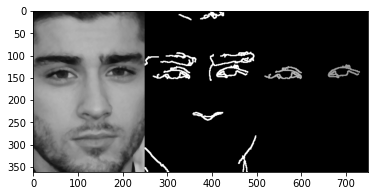

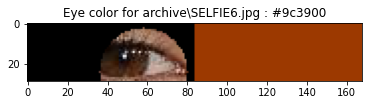

In [5]:
files=glob('archive/*.jpg')
for file in files:
    orig_img=cv2.imread(file)
    compute_eyecolor(orig_img,method=1)

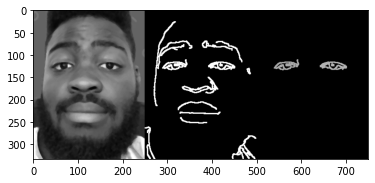

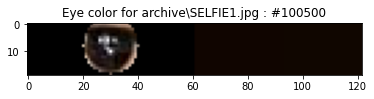

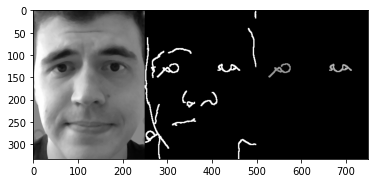

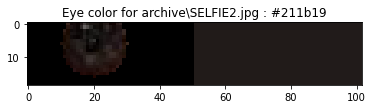

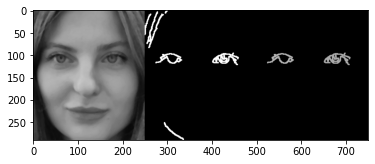

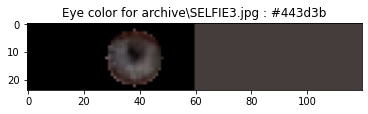

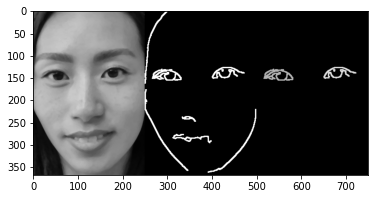

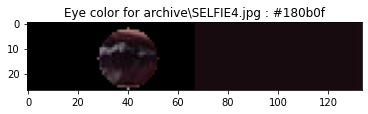

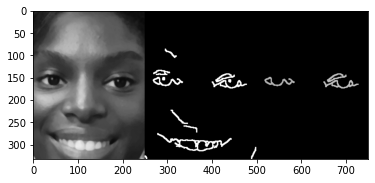

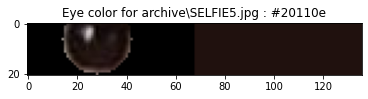

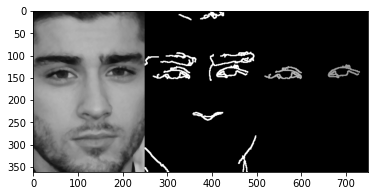

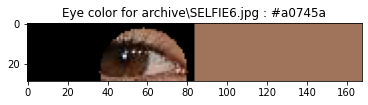

In [4]:
files=glob('archive/*.jpg')
for file in files:
    orig_img=cv2.imread(file)
    compute_eyecolor(orig_img,method=2)